# Convolutional Neural Network for Emotion Recognition

### Importing Modules

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import os
import re
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


---
### Loading Data

In [2]:
structured_datasets = {"train": {}, "test": {}}
directories = {"train": "../data/train", "test": "../data/test"}

for dataset, directory in directories.items():
    for dirpath, _, filenames in os.walk(directory):
        for filename in filenames:
            if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
                continue

            full_path = os.path.join(dirpath, filename)
            img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            emotion = os.path.basename(dirpath)
            if emotion not in structured_datasets[dataset]:
                structured_datasets[dataset][emotion] = []

            structured_datasets[dataset][emotion].append(img)


labels = {
    emotion: i for i, emotion in enumerate(sorted(structured_datasets["train"].keys()))
}

In [3]:
print(labels)

{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3}


In [17]:
x_train_py = []
y_train_py = []

for emotion, images in structured_datasets["train"].items():
  x_train_py.extend(images)
  output = [0, 0, 0, 0]
  output[labels[emotion]] = 1
  y_train_py.extend([output for _ in range(len(images))])

x_test_py = []
y_test_py = []

for emotion, images in structured_datasets["test"].items():
  x_test_py.extend(images)
  output = [0, 0, 0, 0]
  output[labels[emotion]] = 1
  y_test_py.extend([output for _ in range(len(images))])

x_train = np.array(x_train_py)
y_train = np.array(y_train_py)
x_test = np.array(x_test_py)
y_test = np.array(y_test_py)

In [18]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


---

### Model Architecture

* First Model: Less neurons but more layers

In [20]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 95796002038580062
xla_global_id: -1
]


In [21]:
import psutil
print(f"RAM libre: {psutil.virtual_memory().available / 1024**3:.2f} GB")


RAM libre: 4.12 GB


In [22]:
import tensorflow as tf

# Definición del modelo
model = tf.keras.Sequential([
    tf.keras.layers.Input((48, 48, 1)),

    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(4, activation='softmax') 
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train[:5000], y_train[:5000],
    validation_data=(x_val[:500], y_val[:500]),
    epochs=20,
    batch_size=16
)


Epoch 1/20
313/313 [==============================] - 5s 11ms/step - loss: 1.7031 - accuracy: 0.3070 - val_loss: 1.3478 - val_accuracy: 0.3560
Epoch 2/20
313/313 [==============================] - 3s 11ms/step - loss: 1.4482 - accuracy: 0.3652 - val_loss: 1.2666 - val_accuracy: 0.4340
Epoch 3/20
313/313 [==============================] - 4s 12ms/step - loss: 1.3248 - accuracy: 0.4144 - val_loss: 1.2516 - val_accuracy: 0.4480
Epoch 4/20
313/313 [==============================] - 4s 11ms/step - loss: 1.2421 - accuracy: 0.4492 - val_loss: 1.2122 - val_accuracy: 0.4600
Epoch 5/20
313/313 [==============================] - 4s 12ms/step - loss: 1.1753 - accuracy: 0.4846 - val_loss: 1.1365 - val_accuracy: 0.5020
Epoch 6/20
313/313 [==============================] - 4s 12ms/step - loss: 1.1465 - accuracy: 0.5036 - val_loss: 1.1381 - val_accuracy: 0.4900
Epoch 7/20
313/313 [==============================] - 4s 12ms/step - loss: 1.1130 - accuracy: 0.5216 - val_loss: 1.1090 - val_accuracy: 0.4920

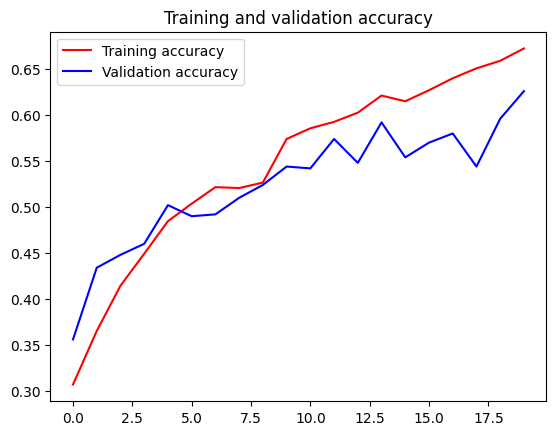

<Figure size 640x480 with 0 Axes>

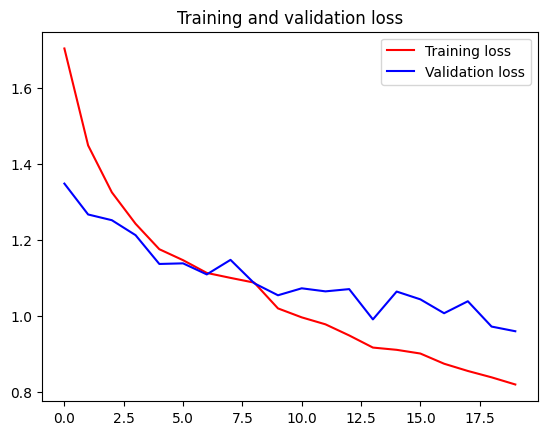

In [23]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

163/163 [==============================] - 1s 6ms/step
0.5970836531082118


<Axes: >

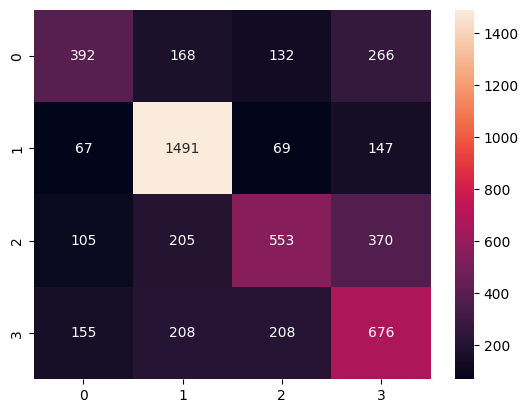

In [24]:
y_pred: np.ndarray = model.predict(x_test)
y_pred = y_pred
conf_y_test = np.array([list(y).index(1) for y in y_test])
conf_y_pred = np.array([y.argmax(axis=0) for y in y_pred])
confmat = confusion_matrix(conf_y_test, conf_y_pred)
print(np.array(confmat).diagonal().sum() / np.array(confmat).sum())
sn.heatmap(confmat, annot=True, fmt="d")
     


In [25]:
model.save("../models/emotion_cnn_model-1.h5")

c:\Users\deaqu\Documents\Workshop_Texas\cnn-emotion-recognition-upy\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


* Second model: Less layers but more neurons


In [26]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Input((48, 48, 1)),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='relu'),  
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(4, activation='softmax')  
])

model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model2.fit(
    x_train[:5000], y_train[:5000],
    validation_data=(x_val[:500], y_val[:500]),
    epochs=20,
    batch_size=16
)


Epoch 1/20
313/313 [==============================] - 36s 112ms/step - loss: 1.7266 - accuracy: 0.3586 - val_loss: 1.4897 - val_accuracy: 0.4500
Epoch 2/20
313/313 [==============================] - 35s 110ms/step - loss: 1.3199 - accuracy: 0.4390 - val_loss: 1.2303 - val_accuracy: 0.4720
Epoch 3/20
313/313 [==============================] - 35s 110ms/step - loss: 1.1717 - accuracy: 0.5022 - val_loss: 1.1968 - val_accuracy: 0.4940
Epoch 4/20
313/313 [==============================] - 34s 110ms/step - loss: 1.0821 - accuracy: 0.5450 - val_loss: 1.3720 - val_accuracy: 0.4620
Epoch 5/20
313/313 [==============================] - 35s 110ms/step - loss: 1.0456 - accuracy: 0.5694 - val_loss: 6.2733 - val_accuracy: 0.3980
Epoch 6/20
313/313 [==============================] - 35s 111ms/step - loss: 0.9957 - accuracy: 0.5874 - val_loss: 4.1449 - val_accuracy: 0.4660
Epoch 7/20
313/313 [==============================] - 35s 111ms/step - loss: 0.9026 - accuracy: 0.6348 - val_loss: 1.1573 - val_ac

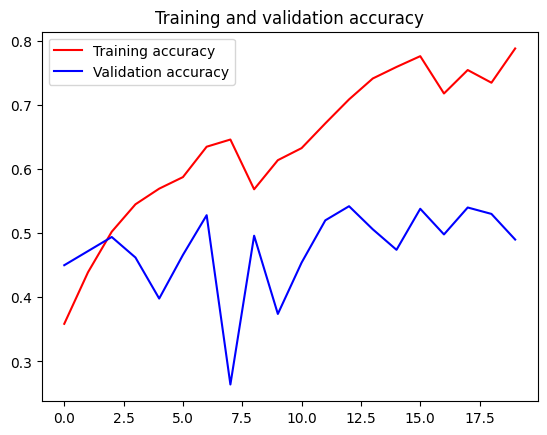

<Figure size 640x480 with 0 Axes>

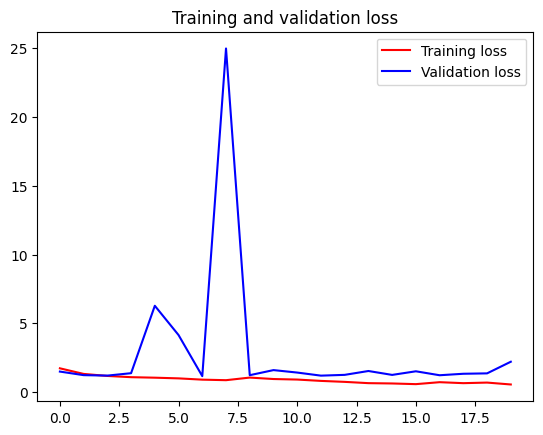

In [27]:
accuracy2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs2 = range(len(accuracy2))

plt.plot(epochs2, accuracy2, 'r', label='Training accuracy')
plt.plot(epochs2, val_acc2, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs2, loss2, 'r', label='Training loss')
plt.plot(epochs2, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

163/163 [==============================] - 4s 24ms/step
{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3}
0.49386032233307753


<Axes: >

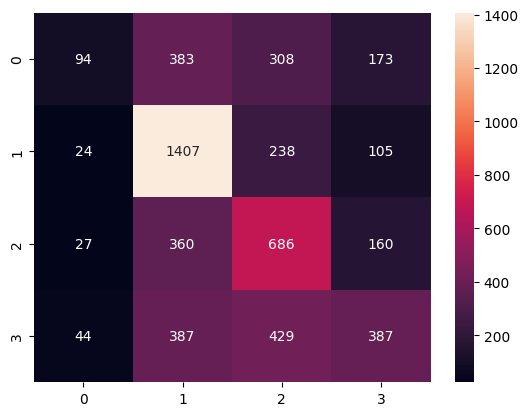

In [28]:
y_pred2: np.ndarray = model2.predict(x_test)
y_pred2 = y_pred2
conf_y_test = np.array([list(y).index(1) for y in y_test])
conf_y_pred2 = np.array([y.argmax(axis=0) for y in y_pred2])
confmat2 = confusion_matrix(conf_y_test, conf_y_pred2)
print(labels)
print(np.array(confmat2).diagonal().sum() / np.array(confmat2).sum())
sn.heatmap(confmat2, annot=True, fmt="d")

In [29]:
model2.save("../models/emotion_cnn_model-2.h5")

c:\Users\deaqu\Documents\Workshop_Texas\cnn-emotion-recognition-upy\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
